# Overview

This notebook visualizes data from the [Jiang et al. 2021](https://www.frontiersin.org/articles/10.3389/fcell.2021.743421/full) zebrafish cell atlas, sample ["Brain8"](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3768152), to compare expression of specific genes to corresponding Orthogroups or Structural clusters.

# 0. Setup

Import packages and specify any important functions here.


If `arcadia_pycolor` is not yet installed, run:
```
!pip install git+https://github.com/Arcadia-Science/arcadia-pycolor.git#egg=arcadia_pycolor --upgrade
```

In [1]:
# import standard python packages
import pandas as pd
import subprocess
import os
import dill
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import numpy as np
import arcadia_pycolor as apc

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

apc.mpl_setup()

# add the utils and env directories to the path
import sys
sys.path.append('../../utils/')
sys.path.append('../../env/')

# import functions from utils directory files
from string_functions import *
from biofile_handling import *
from scanpy_wrappers import *

# import paths to software installs from env
from install_locs import *

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.7


# 1. Load BioFileDocket

Load in the BioFileDocket file for this dataset using `BioFileDocket.unpickle()`

In [2]:
################
# general info #
################

# Specify the name of the species folder in Amazon S3
species = 'Danio_rerio'

# Specify any particular identifying conditions, eg tissue type:
conditions = 'adultbrain'

################

sample_BFD = BioFileDocket(species, conditions).get_from_s3().unpickle()
sample_BFD.s3_to_local()

/home/ec2-user/glial-origins/output/Drer_adultbrain/ already exists
Files will be saved into /home/ec2-user/glial-origins/output/Drer_adultbrain/
file Drer_adultbrain_BioFileDocket.pkl already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/Drer_adultbrain_BioFileDocket.pkl
file GCF_000002035.5_GRCz10_genomic.gff already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GCF_000002035.5_GRCz10_genomic.gff
file GCF_000002035.5_GRCz10_genomic.fna already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GCF_000002035.5_GRCz10_genomic.fna
file GSM3768152_Brain_8_dge.txt already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GSM3768152_Brain_8_dge.txt
file Drer_adultbrain_ZFIN_UniProtIDs.txt already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/Drer_adultbrain_ZFIN_UniProtIDs.txt
file Drer_adultbrain_uniprot-idmm.tsv already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/Drer_adultbrain_uniprot-idmm.tsv
file

# 2. Load gxc and exc files

In [3]:
gxc = pd.read_csv(sample_BFD.gxc.path, sep = '\t')
display(gxc)
og_exc = pd.read_csv(sample_BFD.Orthogroup_exc.path, sep = '\t')
display(og_exc)
sc_exc = pd.read_csv(sample_BFD.StruCluster_exc.path, sep = '\t')
display(og_exc)

,GENE,ACAATATATTGTACCTGA,ACGTTGATGGCGTAGAGA,AACCTAACCTGAATTTGC,CTCGCAGCCCTCTATGTA,ACGTTGCGTATTTAGTCG,AACCTATAGAGACCGACG,ACGAGCGCTGTGGCCTAG,GCGAATGGACATGGACAT,TCTACCGCTCAAGCTCAA,...,CGGCAGTCAAAGATCTCT,GACACTGCGAATCTGTGT,GCAGGAGGCTGCTAAGGG,TATGTATACTTCCGCACC,TGGATGTTCCGCACAATA,AACCTATGGATGGGGTTT,AAGCGGAGGACTCTCCAT,ACCTGACTCGCAAGCGAG,ACGTTGCAAAGTTTCATA,ATCAACTGCAATTTCCGC
0,ABCF3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACOT12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACSF3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACTC1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACVR1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20802,zwilch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20803,zyg11,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
20804,zyx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20805,zzef1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Orthogroup,ACAATATATTGTACCTGA,ACGTTGATGGCGTAGAGA,AACCTAACCTGAATTTGC,CTCGCAGCCCTCTATGTA,ACGTTGCGTATTTAGTCG,AACCTATAGAGACCGACG,ACGAGCGCTGTGGCCTAG,GCGAATGGACATGGACAT,TCTACCGCTCAAGCTCAA,...,CGGCAGTCAAAGATCTCT,GACACTGCGAATCTGTGT,GCAGGAGGCTGCTAAGGG,TATGTATACTTCCGCACC,TGGATGTTCCGCACAATA,AACCTATGGATGGGGTTT,AAGCGGAGGACTCTCCAT,ACCTGACTCGCAAGCGAG,ACGTTGCAAAGTTTCATA,ATCAACTGCAATTTCCGC
0,OG0000001,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
1,OG0000005,0,1,0,0,0,0,1,0,0,...,0,2,0,0,0,0,0,0,0,0
2,OG0000009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OG0000013,0,1,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,OG0000014,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,OG0030137,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12993,OG0030138,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12994,OG0030140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12995,OG0030141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Orthogroup,ACAATATATTGTACCTGA,ACGTTGATGGCGTAGAGA,AACCTAACCTGAATTTGC,CTCGCAGCCCTCTATGTA,ACGTTGCGTATTTAGTCG,AACCTATAGAGACCGACG,ACGAGCGCTGTGGCCTAG,GCGAATGGACATGGACAT,TCTACCGCTCAAGCTCAA,...,CGGCAGTCAAAGATCTCT,GACACTGCGAATCTGTGT,GCAGGAGGCTGCTAAGGG,TATGTATACTTCCGCACC,TGGATGTTCCGCACAATA,AACCTATGGATGGGGTTT,AAGCGGAGGACTCTCCAT,ACCTGACTCGCAAGCGAG,ACGTTGCAAAGTTTCATA,ATCAACTGCAATTTCCGC
0,OG0000001,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
1,OG0000005,0,1,0,0,0,0,1,0,0,...,0,2,0,0,0,0,0,0,0,0
2,OG0000009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OG0000013,0,1,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,OG0000014,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,OG0030137,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12993,OG0030138,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12994,OG0030140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12995,OG0030141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Set the list of IDs of interest

In [4]:
id_list = ['slc1a2b', 'OG0004873', 'SC1105']
#id_list = ['aplnra', 'OG0004819', 'SC21546']

gene_expr = list(gxc.loc[gxc['GENE'] == id_list[0]].squeeze())[1:]
og_abun = list(og_exc.loc[og_exc['Orthogroup'] == id_list[1]].squeeze())[1:]
sc_abun = list(sc_exc.loc[sc_exc['StruCluster'] == id_list[2]].squeeze())[1:]

# 4. Make plots

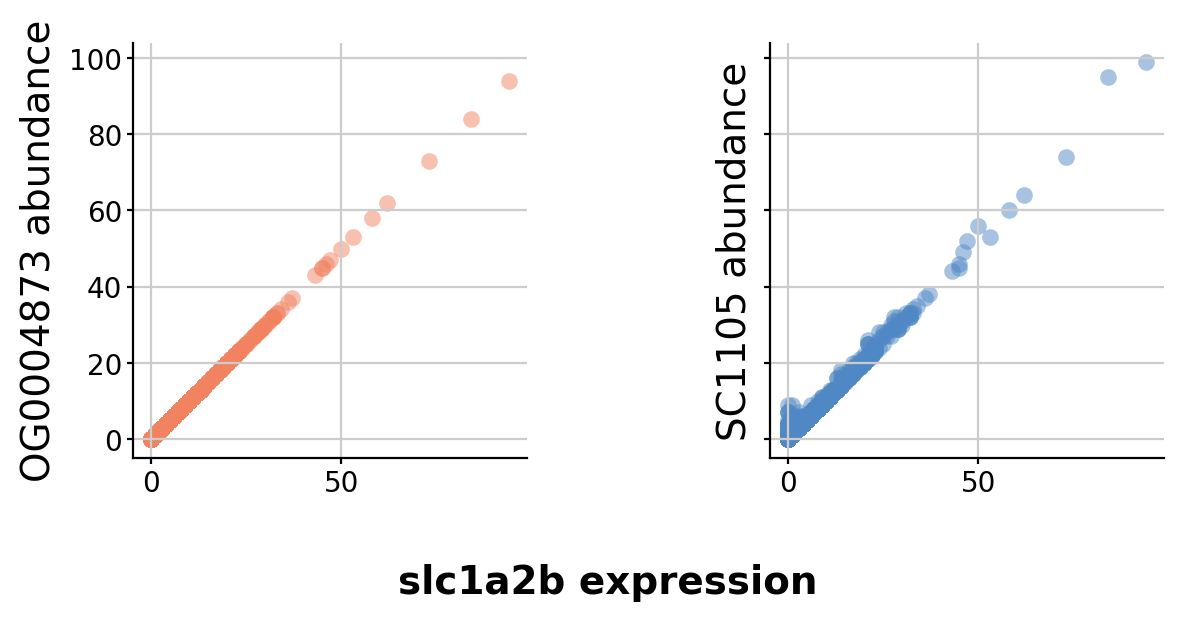

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
fig.set_figheight(3)
fig.set_figwidth(7)

ax1.scatter(x = gene_expr, y = og_abun, alpha = 0.5, c = 'arcadia:amber')
ax1.set_aspect('equal')
ax1.set(ylabel = f'{id_list[1]} abundance')

ax2.scatter(x = gene_expr, y = sc_abun, alpha = 0.5, c = 'arcadia:aegean')
ax2.set_aspect('equal')
ax2.set(ylabel = f'{id_list[2]} abundance')

fig.supxlabel(f'{id_list[0]} expression')
plt.tight_layout()

plt.savefig(f'{sample_BFD.species_prefix}_{id_list[0]}_expr_plot.pdf', bbox_inches = 'tight')

plt.show()